In [8]:
import sys
sys.path.append("..")

#import the jaxified ELR model
from core import ELR, utils

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap

#packages to plot the star using realistic blackbody colors
from colorsys import rgb_to_hls, hls_to_rgb, rgb_to_hsv, hsv_to_rgb
from colorpy import colormodels
from colorpy import blackbody

#Flatiron institute nonuniform fast fourier transform
#will be used to FT the data for interferometric observables
#from jax_finufft import nufft1
from scipy.spatial import ConvexHull

## The ELR model, end to end:

Let's start by writing out the ELR model, but this time reading in the functions we orginally defined in interferometric_oblate_model.ipynb from a script. 

In [246]:
%%time
omega = 0.0001
N = 31

#final function should have omega and r_eq as the only input variables
#should be jittable and definitely graddable
#can pass in theta, n, phi and hull through scope, not explicitly inputs to the func?

thetas = jnp.linspace(0,jnp.pi,N)
ns = utils.closest_polygon(thetas)
#should ideally find a faster implementation since this function can't be jitted or vmapped
phi = jnp.concatenate([jnp.linspace(0,2*jnp.pi,n, endpoint=False) for n in ns])

rtws, Ts, Fs = ELR.solve_ELR_vec(omega, thetas)
Fs = (Fs/jnp.max(Fs))

rtw, T, F, theta = utils.revolve(thetas, rtws, Ts, Fs, ns)
x, y, z = utils.spherical_to_cartesian(rtw,theta,phi)

points = jnp.stack([x,y,z],axis=1)

#should consider computing this for a dummy point cloud where rtw is all ones
#same set of simplices can be applied for all values of omega, theta
hull = ConvexHull(points)
points_rotated = utils.rotate_point_cloud(points, -jnp.pi/4, 0)

# compute the normal vectors
normals = utils.triangle_normals(points_rotated, hull.simplices)
#compute the barycenters (for plotting)
barycenters = utils.barycenter(points_rotated,hull.simplices)

# compute the brightness at the barycenters
brightness_barycenters = F[hull.simplices]
temperature_barycenters = T[hull.simplices]
brightness_barycenters = jnp.mean(brightness_barycenters, axis=1)
temperature_barycenters = jnp.mean(temperature_barycenters,axis=1)

# compute the areas of the triangles
areas = utils.triangle_area(points_rotated, hull.simplices)
# normalize the brightness by the area
brightness_barycenters = brightness_barycenters
temperature_barycenters = temperature_barycenters

# select triangles with positive z component of the normal vector
barycenter_temperature = jnp.where(normals[:,2] > 0, temperature_barycenters, 0)
barycenter_brightness = jnp.where(normals[:,2] > 0, brightness_barycenters, 0)
# delete the z axis from the barycenters
mask = jnp.where(normals[:,2] > 0, True, False)
barycenters_projected = jnp.delete(barycenters[mask], 2, axis=1)

CPU times: user 36.7 ms, sys: 2.51 ms, total: 39.2 ms
Wall time: 37.1 ms


<IPython.core.display.Javascript object>


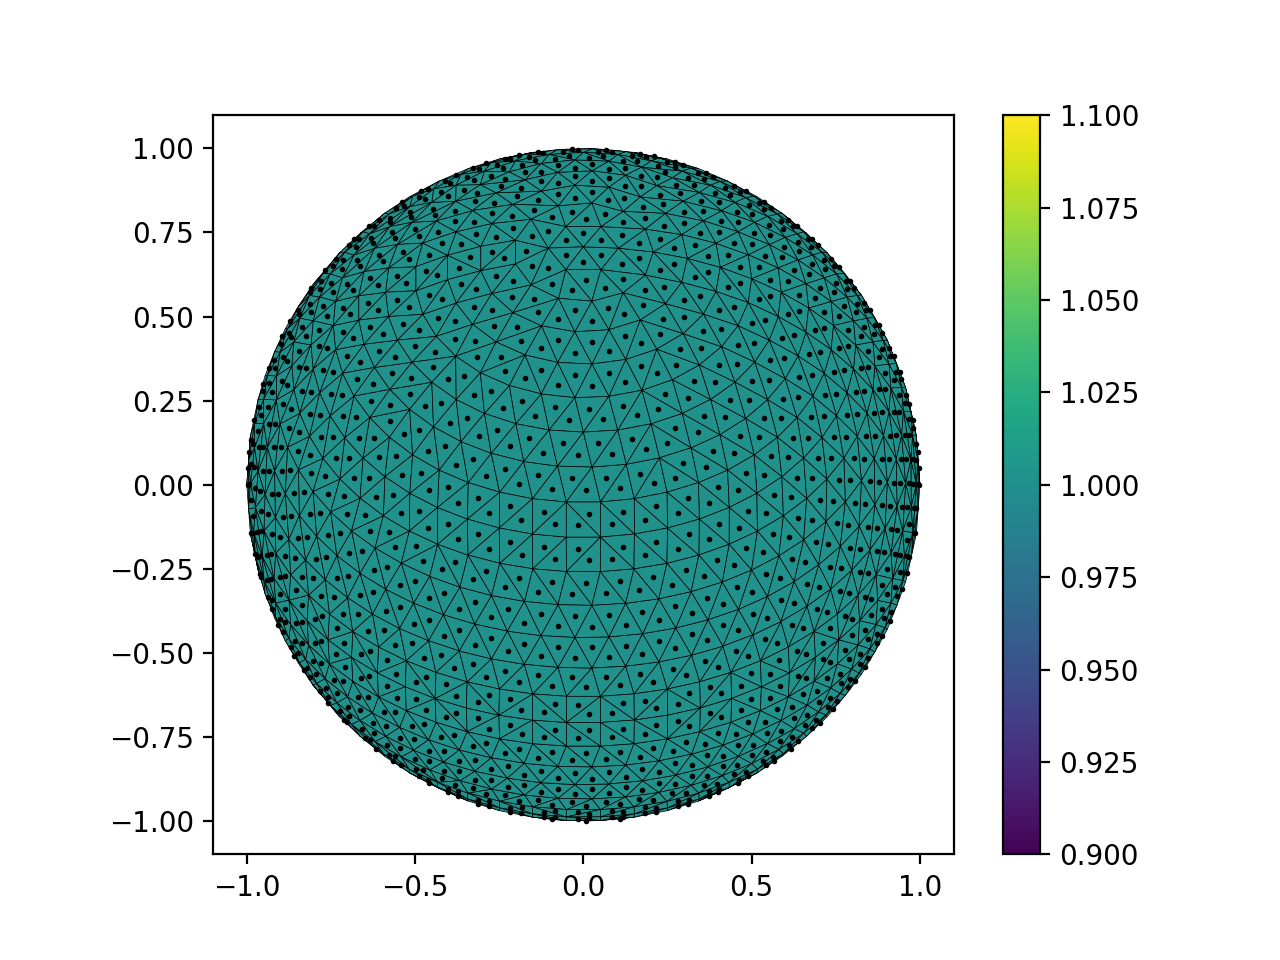

In [247]:
%config InlineBackend.figure_format = 'svg'
mask = jnp.where(normals[:,2] > 0, True, False)
colors = (barycenter_brightness[mask]).astype(np.float32)
#plt.plot(points_rotated[:,0], points_rotated[:,1], 'ko',ms=5);
c = plt.tripcolor(points_rotated[:,0], points_rotated[:,1],triangles=hull.simplices[mask], facecolors=colors,edgecolors='k');
plt.colorbar(c)
plt.plot(barycenters_projected[:,0], barycenters_projected[:,1], 'ko',ms=1);
plt.gca().set_aspect('equal')

In [248]:
def compute_DFTM1(x,y,uv,wavel):
    '''Compute a direct Fourier transform matrix, from coordinates x and y (milliarcsec) to uv (metres) at a given wavelength wavel.'''

    # Convert to radians
    x = x * jnp.pi / 180.0 / 3600.0/ 1000.0
    y = y * jnp.pi / 180.0 / 3600.0/ 1000.0

    # get uv in nondimensional units
    uv = uv / wavel

    # Compute the matrix
    dftm = jnp.exp(-2j* jnp.pi* (jnp.outer(uv[:,0],x)+jnp.outer(uv[:,1],y)))

    return dftm

def apply_DFTM1(image,dftm):
    '''Apply a direct Fourier transform matrix to an image.'''
    image /= image.sum()
    return np.dot(dftm,image.ravel())

In [249]:
u, v = np.linspace(-500,500,64), np.linspace(-500,500,64)
wavel = 1e-6 # m

uu, vv = np.meshgrid(np.linspace(-500,500,64),np.linspace(-500,500,64))
uvgrid = np.vstack((uu.flatten(),vv.flatten())).T
dftm_test = compute_DFTM1(barycenters[:,0], barycenters[:,1], uvgrid, wavel)
ft = apply_DFTM1(barycenter_brightness*areas,dftm_test)

In [250]:
from scipy.special import j1
mas2rad = jnp.pi / 180.0 / 3600.0/ 1000.0

def airy(uv, lam, diam):
    '''Airy function for a circular aperture, evaluated on baselines uv (m) with diameter diam (mas) at wavelength lam (m)'''
    
    r = np.sqrt(uv[:,0]**2 + uv[:,1]**2)/lam

    d = diam*mas2rad

    return 2 * j1(jnp.pi * r * d) / (jnp.pi * r * d)

<IPython.core.display.Javascript object>


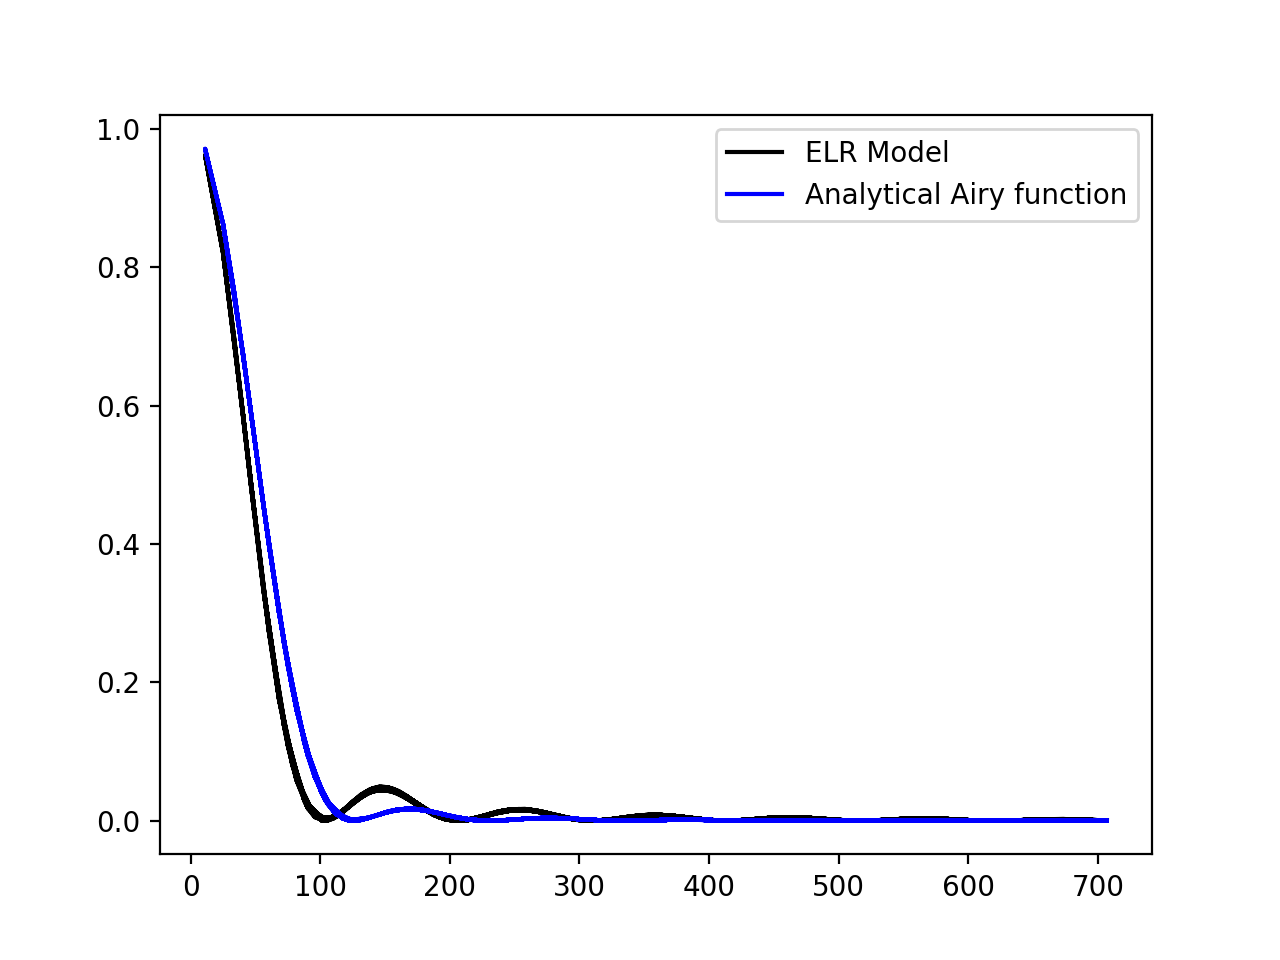

In [251]:
%matplotlib notebook
wgrid = np.sqrt(uvgrid[:,0]**2 + uvgrid[:,1]**2)
ft_anal = airy(uvgrid, wavel,2)
v2, phase = jnp.abs(ft)**2, jnp.angle(ft)
v2_anal, phase_anal = jnp.abs(ft_anal)**2, jnp.angle(ft_anal)
plt.plot(wgrid,v2,'k', label='ELR Model')
plt.plot(wgrid,v2_anal, 'b', label='Analytical Airy function')
plt.legend()